In [1]:
'''GENERAL'''
import os
import warnings
warnings.simplefilter('ignore')
import random
import collections
import math
import itertools
import glob
'''DATA'''
import numpy as np
import pandas as pd
'''PLOT'''
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.style.use('seaborn-pastel')
font = {'size':16}
import seaborn as sns
'''STATS'''
import statsmodels.api as sm
'''SCIKIT LEARN'''
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, r2_score, mean_squared_error, classification_report, make_scorer, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.cluster import KMeans
'''TENSORFLOW'''
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing import text
from tensorflow.keras import utils
'''PALETTE'''
twi = '#DCB8E7' #Pale, light grayish mulberry
twi_blu = '#273873' #Dark sapphire blue
twi_pur = '#662D8A' #Moderate purple
twi_pnk = '#ED438D' #Brilliant raspberry
'''RETURN'''
!fortune | cowsay -f dragon


 ________________________________________ 
/ Increased knowledge will help you now. \
\ Have mate's phone bugged.              /
 ---------------------------------------- 
      \                    / \  //\
       \    |\___/|      /   \//  \\
            /0  0  \__  /    //  | \ \    
           /     /  \/_/    //   |  \  \  
           @_^_@'/   \/_   //    |   \   \ 
           //_^_/     \/_ //     |    \    \
        ( //) |        \///      |     \     \
      ( / /) _|_ /   )  //       |      \     _\
    ( // /) '/,_ _ _/  ( ; -.    |    _ _\.-~        .-~~~^-.
  (( / / )) ,-{        _      `-.|.-~-.           .~         `.
 (( // / ))  '/\      /                 ~-. _ .-~      .-~^-.  \
 (( /// ))      `.   {            }                   /      \  \
  (( / ))     .----~-.\        \-'                 .~         \  `. \^-.
             ///.----..>        \             _ -~             `.  ^-`  ^-_
               ///-._ _ _ _ _ _ _}^ - - - - ~                     ~-- ,.-~
   

# Processing

I have to start from scratch since the previous features I selected did not contain any signal.

I read in all of my csvs as on big dataframe so I can work with it easily.

In [21]:
# Gather list of raw data filenames
raw = glob.glob(os.path.join('data/raw', '*.csv'))
files = sorted(raw)
files[-5:]

['data/raw/2019-06-20.csv',
 'data/raw/2019-06-21.csv',
 'data/raw/2019-06-22.csv',
 'data/raw/2019-06-23.csv',
 'data/raw/2019-06-24.csv']

In [15]:
# read in all files and concatanate
df = pd.concat((pd.read_csv(f) for f in files))
df.shape

(1831760, 81)

### Sampling

18 million observations would take way too much computational power to work with, so I sample only the most recent data based on game version.

In [17]:
# get the most recent game version
sorted(df['game-ver'].unique())[-1]

'4.8.0'

In [17]:
# check number of observations
np.sum(df['game-ver']=='4.8.0')

56751

In [18]:
# 57 thousand is plenty, so I decide to use it
df = df[df['game-ver']=='4.8.0']
df.shape

(56751, 81)

### Feature Engineering

My current data is one observation for each match, however since I want to draw conslusions on players and teams, I need to split each observation into two. Thankfully Splatoon 2 does not allow ties and I can always split each match into a winning team and losing team to avoid class imbalances.

In [3]:
def splatoon_explode(df):
    """ 
    Explodes rows of stat.ink dataframes into one row for each team.
    Feature names are hardcoded according to stat.ink conventions due to the sheer number of them.
    Aggregates the data by taking the mean of the teammates.
  
    Parameters: 
    df (DataFrame): Pandas dataframe on which to explode
  
    Returns: 
    Dataframe: Exploded dataframe
  
    """
    # features for all players
    shared = ['game-ver', 'lobby-mode', 'lobby', 'mode', 'stage']
    # features for each team
    team = ['kill', 'assist', 'death', 'special', 'inked', 'level']
    a_team = ['A1-', 'A2-', 'A3-', 'A4-']
    b_team = ['B1-', 'B2-', 'B3-', 'B4-']
    for feat in team:
        df['A'+feat[0]] = df[[player+feat for player in a_team]].mean(axis=1)
        df['B'+feat[0]] = df[[player+feat for player in b_team]].mean(axis=1)       
    # initialize temporary storage list
    tmp = collections.deque()
    # iterate through rows
    for index, row in df.iterrows():
        # get features common to both teams
        both = row[shared].tolist()
        # create team A row
        tmp.append(both + row[['Ak', 'Aa', 'Ad', 'As', 'Ai', 'Al']].tolist() + [row.win == 'alpha'])
        # create team B row
        tmp.append(both + row[['Bk', 'Ba', 'Bd', 'Bs', 'Bi', 'Bl']].tolist() + [row.win == 'bravo'])
    # create new column names, including the index of the match the data was from
    new_cols = shared + ['kill', 'assist', 'death', 'special', 'inked', 'level', 'win']
    # return new dataframe
    return pd.DataFrame(list(tmp), columns=new_cols)

The function takes a long time to run but outputs exactly what I want.

In [4]:
df = splatoon_explode(df)
df.head()

,game-ver,lobby-mode,lobby,mode,stage,kill,assist,death,special,inked,level,win
0,4.8.0,regular,standard,nawabari,ajifry,4.00,3.00,2.50,2.75,932.50,93.25,True
1,4.8.0,regular,standard,nawabari,ajifry,2.50,0.50,4.00,2.00,754.75,76.25,False
2,4.8.0,regular,standard,nawabari,ama,1.50,0.75,3.75,2.75,958.00,61.75,False
3,4.8.0,regular,standard,nawabari,ama,3.75,0.25,1.75,3.75,1020.25,157.00,True
4,4.8.0,gachi,standard,hoko,manta,7.00,2.00,8.25,2.75,1016.25,329.50,False


Thanks to the clean data I am using, I do not have any missing values to deal with. If nessecary, I have plenty of observations to drop rows with missing values.

In [19]:
np.sum(df.isnull())

game-ver      0
lobby-mode    0
lobby         0
mode          0
stage         0
kill          0
assist        0
death         0
special       0
inked         0
level         0
win           0
dtype: int64

Save the dataframe to pickle so I do not have to run that function every time.

In [2]:
# save as pickle
# df.to_pickle('data/by_team.pkl')
# load from pickle for future notebook use
df = pd.read_pickle('data/by_team.pkl')

# EDA

Attempted to start with a heatmap, but dataset was too large and took very long to run.

In [2]:
# corr = df[['kill', 'assist', 'death', 'special', 'inked', 'level']]
# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap="coolwarm");

### Overlapping Histograms

Due to this being a pivot from my original project, I needed to quickly determine if I could make predictions using these new features. These histograms are not the best way to show data but tell me enough about the distribution.

In [42]:
def hist_plotter(col, df=df):
    '''
    A simple overlapping histogram plotter with too many hard-coded variables.
    
    Input:
    col (str): name of collumn to plot histogram of
    df (dataframe): dataframe containing data to plot with and a win column to split on
    
    Output:
    None: displays a plot on jupyter notebook
    '''
    win = df[df.win == True][col].tolist()
    lose = df[df.win == False][col].tolist()
    plt.figure(figsize=(12, 6))
    plt.hist(lose, label = 'lose', color = 'r', alpha = .4)
    plt.hist(win, label = 'win', color = 'b', alpha = .4)
    plt.title(col)
    plt.legend()
    return None

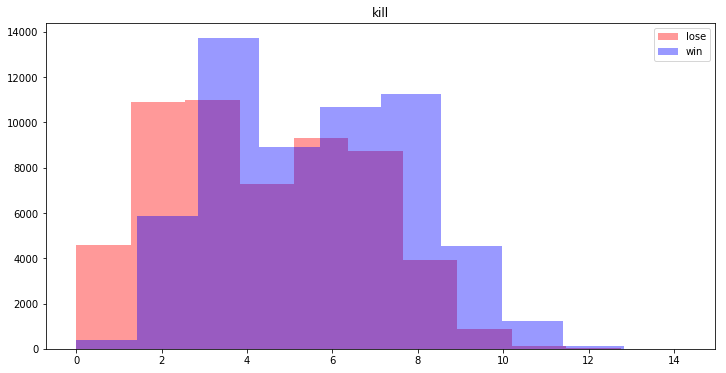

In [49]:
hist_plotter('kill')
# plt.savefig('img/kill.png')

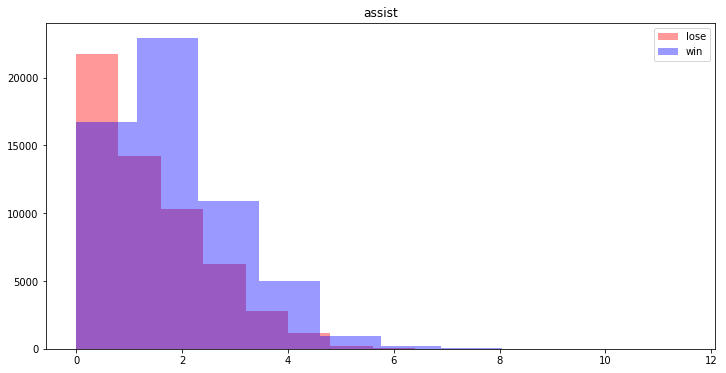

In [50]:
hist_plotter('assist')
# plt.savefig('img/assist.png')

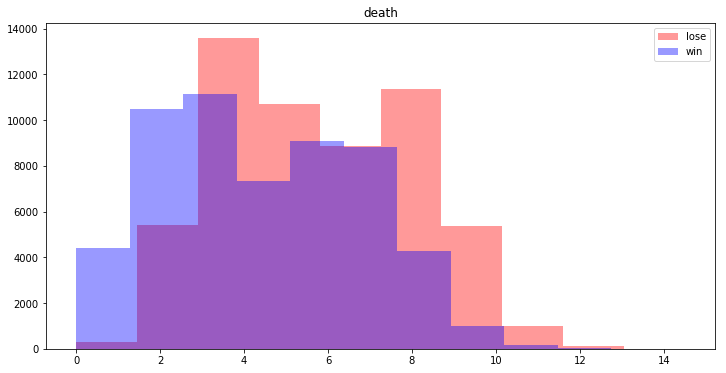

In [45]:
hist_plotter('death')

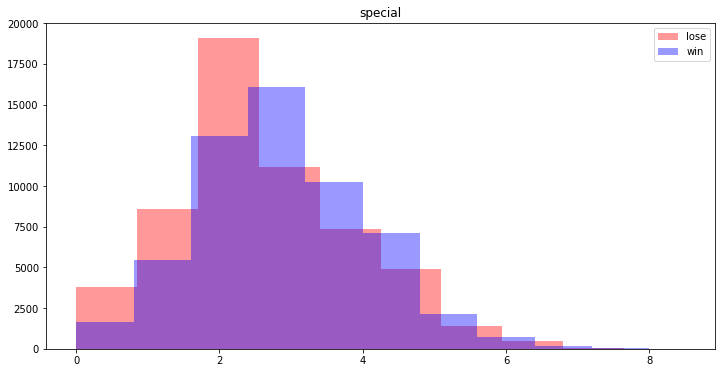

In [46]:
hist_plotter('special')

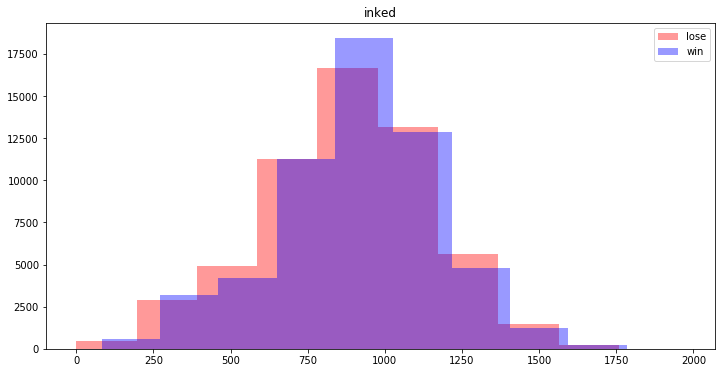

In [51]:
hist_plotter('inked')
# plt.savefig('img/inked.png')

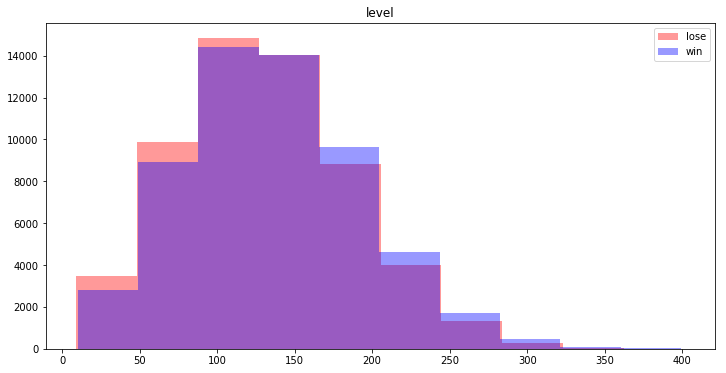

In [48]:
hist_plotter('level')

There is actually a difference in distribution unlike my previous features. I am cautiously optomistic this time.

# Modeling

I first make dummies of my categorical data and standardize my numerical data. Then I train test split with 1/3 as the test set as I have plenty of observations.

In [3]:
# split into features and label
X = df[['mode', 'kill', 'assist', 'death', 'special', 'inked', 'level']]
y = df['win']
# make dummies of game type
X = pd.get_dummies(X)
# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Logistic Regression

The simplest model, but suprisingly accurate and easy to understand.

In [7]:
lr = LogisticRegression(penalty='l1', solver='saga')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8019275950448527

This is good as the accuracy is decent and I can use inferential regression later.

### Random Forest

Only did a little better than logistic regression, granted I did not spend too much time tuning the hyperparameters.

In [6]:
rf = RandomForestClassifier(n_estimators=100, max_depth=20)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8031023067065357

### Gradient Boosting

Even using a gridsearch to tune hyperparameters, it only managed less than 0.002 better accuracy than the logistic regression.

In [4]:
gb = GradientBoostingClassifier(learning_rate=0.05, n_estimators=1000, subsample=0.5, max_depth=3,
                                min_impurity_decrease=0)
gb.fit(X_train, y_train)
gb.score(X_test, y_test)

0.8040100384451089

In [110]:
gdbr_grid = {'learning_rate': [0.01, 0.05, 0.1],
             'max_depth': [10, 3, 1],
             'subsample': [1, 0.5],
             'min_impurity_decrease': [0, 0.01],
             'n_estimators': [1000, 100, 10],
             'random_state': [1]}

gdbr_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                               gdbr_grid,
                               n_jobs=-1,
                               cv = 3,
                               verbose=True,
                               scoring='accuracy')
gdbr_gridsearch.fit(X_train, y_train)

print("best parameters:", gdbr_gridsearch.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 18.5min finished


best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_impurity_decrease': 0, 'n_estimators': 1000, 'random_state': 1, 'subsample': 0.5}


### Neural Network

After spending a lot of time manually tuning hyperparameters I finally managed to get a step up from the logistic regression. I would choose this if I wanted a purely predictive model but will still stick to the logistic regression as I can better draw inferences with it.

In [13]:
model = Sequential()
model.add(Dense(units=8, input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, batch_size=50)

Train on 76046 samples
Epoch 1/5
76046/76046 [==============================] - 2s 23us/sample - loss: 0.5307 - accuracy: 0.7336
Epoch 2/5
76046/76046 [==============================] - 2s 22us/sample - loss: 0.4227 - accuracy: 0.8049
Epoch 3/5
76046/76046 [==============================] - 2s 22us/sample - loss: 0.4147 - accuracy: 0.8053
Epoch 4/5
76046/76046 [==============================] - 2s 23us/sample - loss: 0.4119 - accuracy: 0.8061
Epoch 5/5
76046/76046 [==============================] - 2s 23us/sample - loss: 0.4104 - accuracy: 0.8066


In [14]:
# generate metrics based on prediction
y_pred = model.predict_classes(X_test)
print(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.8056653139683896 0.8029042344586359 0.8097274184927846


array([[15027,  3719],
       [ 3560, 15150]])

# Drawing inferences

### Effect Size with Inferential Regression

The Linear Regression Assumptions:
- Linearity
    - My logistic regression model does almost well as Gradient Boosting and Neural Net. This would not be true if the data was not linear.
- Linear Independence
    - Predictors chosen in a way that do not overlap, Kill-Assist was not chosen for this reason.
- Independence
    - Given a large enough sample of matches and 8 players per match, they should be independent even if they were uploaded by a small sample of players.
- Homoscedasticity
    - Data has similar distributions across both classes.
- Normal Distribution of Errors
    - There should be minimal error due to data being directly exported from the game API.

In [15]:
# copied over the logistic regression model from earlier
lr = LogisticRegression(penalty='l1', solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8019275950448527

Next I plot a ROC curver to visualize how well my model is doing.

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


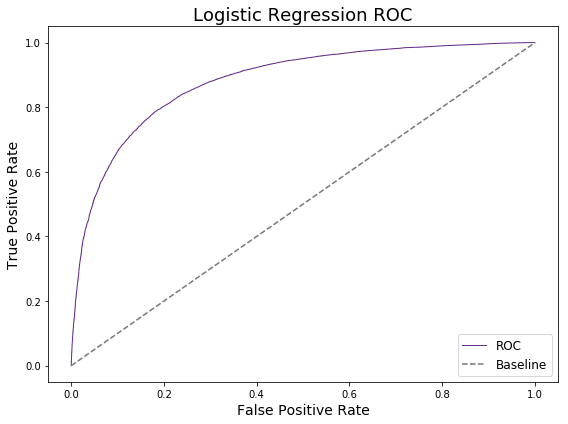

In [16]:
# predict probabilities using previous model
y_prob = lr.predict_proba(X_test)
# use sklearn's roc_curve and auc functions to generate datapoints
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)
# plot the data
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=1, label='ROC', color=twi_pur)
plt.plot([0, 1], [0, 1], '--', color='#777777', label='Baseline')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Logistic Regression ROC', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
# plt.savefig('img/roc.png');

With a decent accuracy and ROC curve, I can move on to the next step of looking at the coeficents.

Text(0, 0.5, 'Feature Name')

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


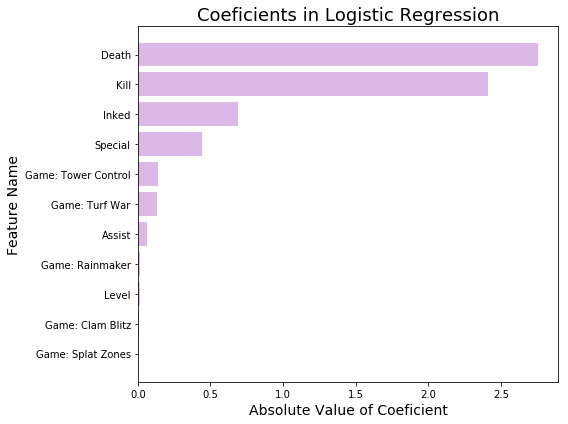

In [17]:
# manually name columns
cols = ['Kill', 'Assist', 'Death', 'Special', 'Inked', 'Level', 'Game: Splat Zones',
       'Game: Clam Blitz', 'Game: Rainmaker', 'Game: Turf War', 'Game: Tower Control']
#get coeficients
values = np.abs(lr.coef_.flatten().tolist())
# plot coeficients
data = [list(x) for x in zip(*sorted(zip(cols, values), key=lambda pair: pair[1]))]
plt.figure(figsize=(8, 6))
plt.barh(data[0], data[1], color=twi)
plt.title("Coeficients in Logistic Regression", fontsize=18)
plt.xlabel('Absolute Value of Coeficient', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)
# plt.savefig('img/coef.png');

It seems like death and kill are the most important by a large margin, no suprise there. However it does appear that death (not dying) is more important than getting kills. Inked and special are also good and it is interesting that inked is more important than special because one of the main motivations for inking is to build special meter.

I will now use statsmodel to get the pvalues of the coeficients.

In [76]:
# add a constant to training data
X_train_c = sm.add_constant(X_train)
# fit statsmodel logistic regression
logit = sm.Logit(y_train, X_train_c)
res = logit.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.433935
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                76046
Model:                          Logit   Df Residuals:                    76035
Method:                           MLE   Df Model:                           10
Date:                Tue, 02 Jul 2019   Pseudo R-squ.:                  0.3740
Time:                        16:24:51   Log-Likelihood:                -32999.
converged:                       True   LL-Null:                       -52711.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0129      0.010     -1.322      0.186      -0.032       0.006
x1             2.4127      0.023    104.525      0.000       2.367       2.458
x2            -0.0627      0.015     -4.108      0.000      -0.093      -0.033
x3            -2.7575      0.022   -127.378      0.000      -2.800      -2.715
x4            -0.4411      0.022    -19.808      0.000      -0.485      -0.397
x5             0.6896      0.026     26.468      0.000       0.639       0.741
x6             0.0132      0.010      1.258      0.209      -0.007       0.034
x7             0.0006    3.7e+05   1.71e-09      1.000   -7.26e+05    7.26e+05
x8            -0.0055   2.81e+05  -1.94e-08      1.000   -5.51e+05    5.51e+05
x9             0.0176   3.35e+05   5.25e-08      1.000   -6.56e+05    6.56e+05
x10           -0.1312   4.01e+05  -3.27e-07      1.000   -7.86e+05    7.86e+05
x11            0.1424   3.37e+05   4.23e-07      1.000    -6.6e+05     6.6e+05
==============================================================================
"""

It seems all the all the features up to the 5th have extremely low p-values and thus are good predictors. This means that level and game mode are poor predictors, which was evidenced by their low coeficients.

### Feature importance with Gradient Boosting

My gradient boosting model was a litte more accurate than my logistic regression, and while it is not as easy to understand as the coeficients from logistic, I can still make inferences using feature importance.

In [21]:
# reuse the model from before
gb = GradientBoostingClassifier(learning_rate=0.05, n_estimators=1000, subsample=0.5, max_depth=3,
                                min_impurity_decrease=0)
gb.fit(X_train, y_train)
gb.score(X_test, y_test)

0.8042236223835968

In [19]:
# a function taken from a galvanize lecture that was shodilly modified for my purposes
def feat_importance(model_opt, names):
    feature_importances = 100*model_opt.feature_importances_ / np.sum(model_opt.feature_importances_)
    feature_importances, feature_names, feature_idxs = \
    zip(*sorted(zip(feature_importances, names, range(len(names)))))
    idx = np.arange(len(names))
    plt.figure(figsize=(8, 6))
    plt.barh(idx, feature_importances, align='center', color=twi)
    plt.yticks(idx, feature_names)
    plt.title("Feature Importance in Gradient Boosting Classifier", fontsize=18)
    plt.xlabel('Relative Importance of Feature', fontsize=14)
    plt.ylabel('Feature Name', fontsize=14);

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


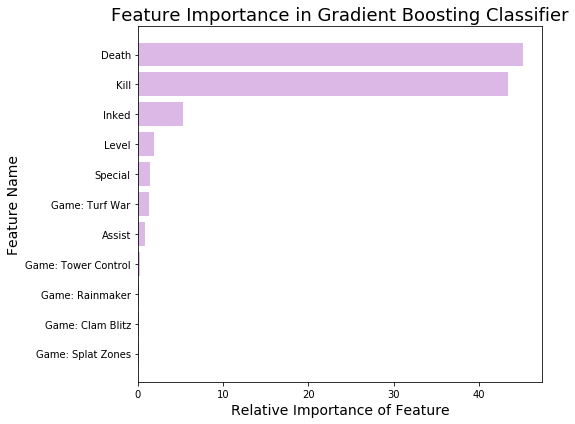

In [22]:
feat_importance(gb, cols)
# plt.savefig('img/feat.png')

Deaths and kills are also the most important here, however they are more evenly weighted. Inked has droped in proportional importance but is still 3rd and handily beats special. Surprisingly, level is now a relatively useful predictor, indicating that it may have a nonlinear correlaton to win rate.